In [8]:
import os
import random
import copy
import math
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import gc
import glob
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset

In [2]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(device)

mps


In [3]:
EPOCHS = 200
LR = 1e-3
BS = 16
SEED = 42
LATENT_SIZE = 64
WINDOWSIZE = 128
ROLLING_WINDOW_SIZE = 30
STEP = 32
MODEL_NAME ='model_1.pth'

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(SEED) # Seed 고정

# EDA 

In [4]:
train_df = pd.read_csv('./dataset/train_data.csv')
test_df = pd.read_csv('./dataset/test_data.csv')

In [150]:
corr = train_df.drop('type',axis=1).corr()
corr

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe
air_inflow,1.000000,0.636467,NaN,0.994585,0.549101,0.659138,0.347755
air_end_temp,0.636467,1.000000,NaN,0.703042,0.990302,0.999506,0.273699
out_pressure,NaN,NaN,NaN,NaN,NaN,NaN,NaN
motor_current,0.994585,0.703042,NaN,1.000000,0.619536,0.723685,0.353014
motor_rpm,0.549101,0.990302,NaN,0.619536,1.000000,0.986419,0.237544
motor_temp,0.659138,0.999506,NaN,0.723685,0.986419,1.000000,0.282746
motor_vibe,0.347755,0.273699,NaN,0.353014,0.237544,0.282746,1.000000


## Data has nan?

In [131]:
train_df.isnull().sum()

air_inflow       0
air_end_temp     0
out_pressure     0
motor_current    0
motor_rpm        0
motor_temp       0
motor_vibe       0
type             0
dtype: int64

## data visualization

In [132]:
train_type_0 = train_df.loc[train_df['type']==0]
train_type_1 = train_df.loc[train_df['type']==1]
train_type_2 = train_df.loc[train_df['type']==2]
train_type_3 = train_df.loc[train_df['type']==3]
train_type_4 = train_df.loc[train_df['type']==4]
train_type_5 = train_df.loc[train_df['type']==5]
train_type_6 = train_df.loc[train_df['type']==6]
train_type_7 = train_df.loc[train_df['type']==7]

train_each_type = []
train_each_type.append(train_type_0)
train_each_type.append(train_type_1)
train_each_type.append(train_type_2)
train_each_type.append(train_type_3)
train_each_type.append(train_type_4)
train_each_type.append(train_type_5)
train_each_type.append(train_type_6)
train_each_type.append(train_type_7)

### air_inflow

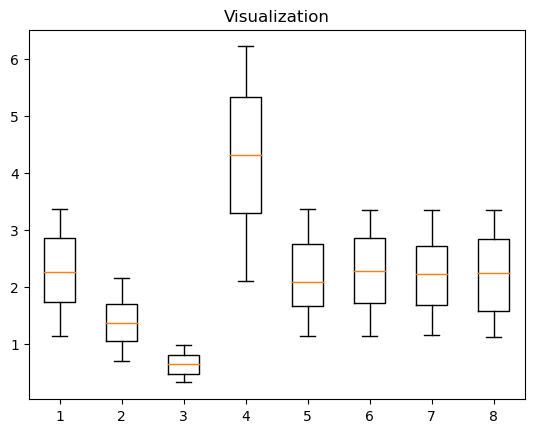

In [37]:
fig, ax = plt.subplots()

ax.boxplot([train_type_0['air_inflow'], train_type_1['air_inflow'], train_type_2['air_inflow'],
           train_type_3['air_inflow'], train_type_4['air_inflow'], train_type_5['air_inflow'],
           train_type_6['air_inflow'], train_type_7['air_inflow']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2,3,4,5,6,7,8])
plt.show()



### air_end_temp

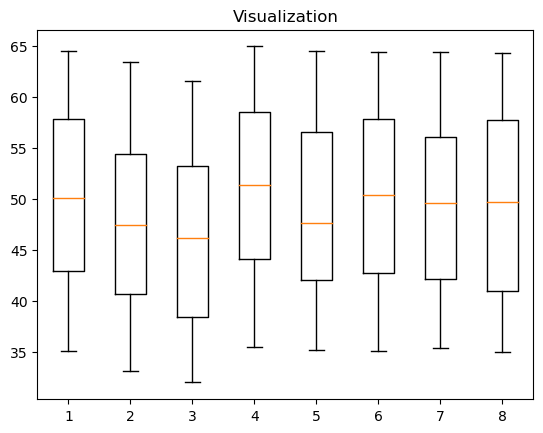

In [38]:
fig, ax = plt.subplots()

ax.boxplot([train_type_0['air_end_temp'], train_type_1['air_end_temp'], train_type_2['air_end_temp'],
           train_type_3['air_end_temp'], train_type_4['air_end_temp'], train_type_5['air_end_temp'],
           train_type_6['air_end_temp'], train_type_7['air_end_temp']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2,3,4,5,6,7,8])
plt.show()



### out_pressure

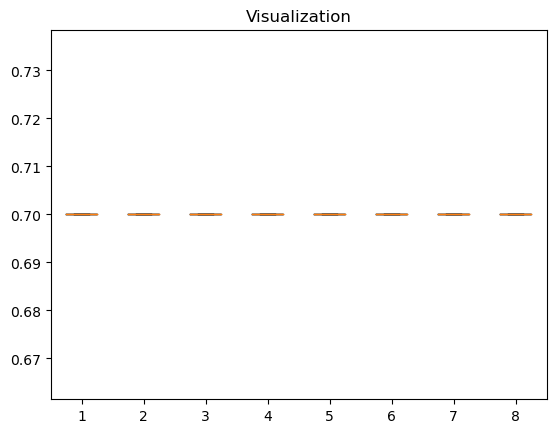

In [39]:
fig, ax = plt.subplots()

ax.boxplot([train_type_0['out_pressure'], train_type_1['out_pressure'], train_type_2['out_pressure'],
           train_type_3['out_pressure'], train_type_4['out_pressure'], train_type_5['out_pressure'],
           train_type_6['out_pressure'], train_type_7['out_pressure']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2,3,4,5,6,7,8])
plt.show()



### motor_current

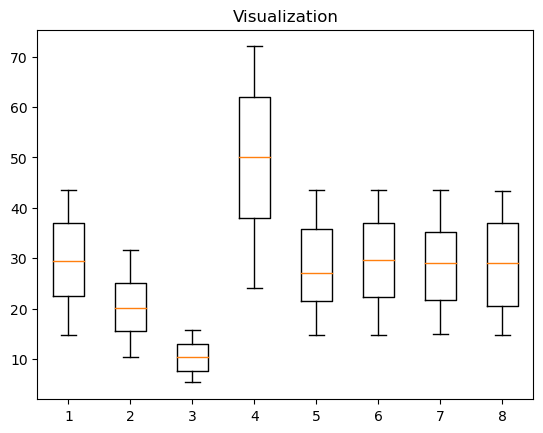

In [40]:
fig, ax = plt.subplots()

ax.boxplot([train_type_0['motor_current'], train_type_1['motor_current'], train_type_2['motor_current'],
           train_type_3['motor_current'], train_type_4['motor_current'], train_type_5['motor_current'],
           train_type_6['motor_current'], train_type_7['motor_current']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2,3,4,5,6,7,8])
plt.show()



### motor_rpm

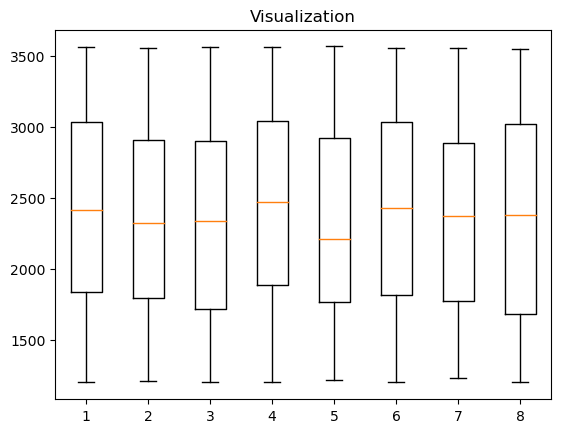

In [41]:
fig, ax = plt.subplots()

ax.boxplot([train_type_0['motor_rpm'], train_type_1['motor_rpm'], train_type_2['motor_rpm'],
           train_type_3['motor_rpm'], train_type_4['motor_rpm'], train_type_5['motor_rpm'],
           train_type_6['motor_rpm'], train_type_7['motor_rpm']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2,3,4,5,6,7,8])
plt.show()



### motor_temp

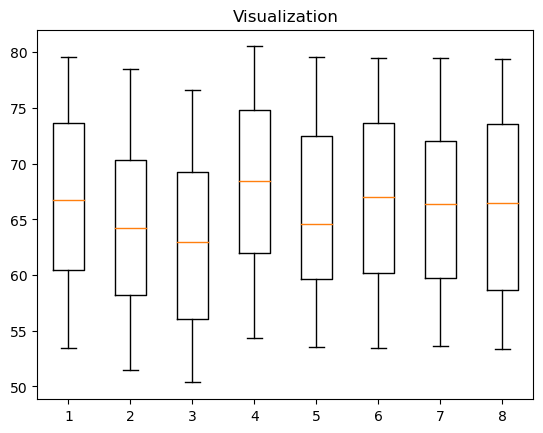

In [42]:
fig, ax = plt.subplots()

ax.boxplot([train_type_0['motor_temp'], train_type_1['motor_temp'], train_type_2['motor_temp'],
           train_type_3['motor_temp'], train_type_4['motor_temp'], train_type_5['motor_temp'],
           train_type_6['motor_temp'], train_type_7['motor_temp']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2,3,4,5,6,7,8])
plt.show()



### motor_vibe

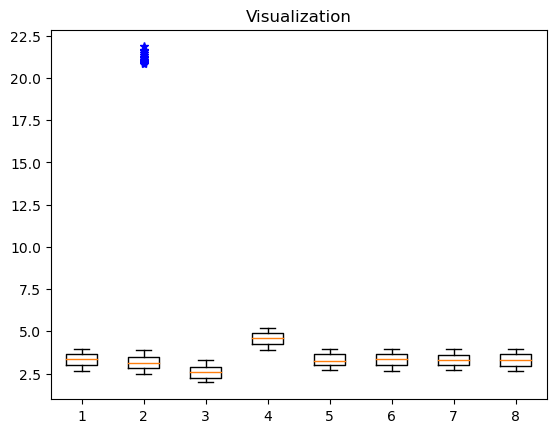

In [44]:
fig, ax = plt.subplots()

ax.boxplot([train_type_0['motor_vibe'], train_type_1['motor_vibe'], train_type_2['motor_vibe'],
           train_type_3['motor_vibe'], train_type_4['motor_vibe'], train_type_5['motor_vibe'],
           train_type_6['motor_vibe'], train_type_7['motor_vibe']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2,3,4,5,6,7,8])
plt.show()



In [51]:
train_type_1.loc[train_type_1['motor_vibe'] > 10]

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
581,0.94,38.69,0.7,13.41,1495.0,56.61,20.83,1
582,1.21,44.14,0.7,17.33,1931.0,61.46,21.07,1
583,1.36,47.04,0.7,19.41,2163.0,64.03,21.20,1
584,1.05,40.83,0.7,14.95,1666.0,58.51,20.93,1
585,1.91,58.00,0.7,27.28,3040.0,73.78,21.69,1
586,1.16,43.15,0.7,16.62,1852.0,60.58,21.03,1
587,1.31,46.09,0.7,18.73,2087.0,63.19,21.16,1
588,0.98,39.46,0.7,13.97,1557.0,57.30,20.87,1
589,1.57,51.31,0.7,22.48,2505.0,67.83,21.39,1
590,1.71,53.96,0.7,24.38,2717.0,70.19,21.51,1


In [56]:
test_type_0 = test_df.loc[test_df['type']==0]
test_type_1 = test_df.loc[test_df['type']==1]
test_type_2 = test_df.loc[test_df['type']==2]
test_type_3 = test_df.loc[test_df['type']==3]
test_type_4 = test_df.loc[test_df['type']==4]
test_type_5 = test_df.loc[test_df['type']==5]
test_type_6 = test_df.loc[test_df['type']==6]
test_type_7 = test_df.loc[test_df['type']==7]

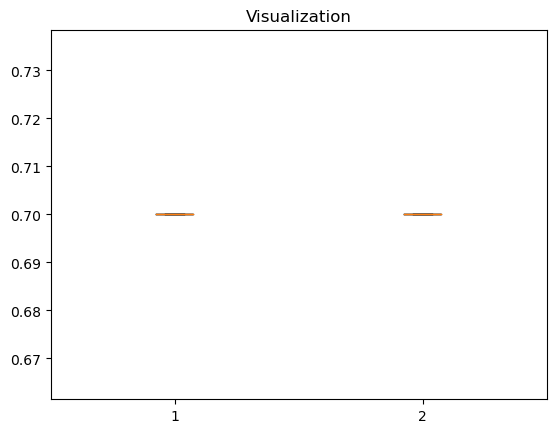

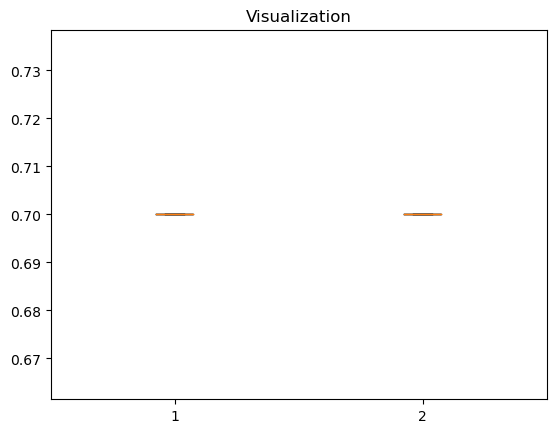

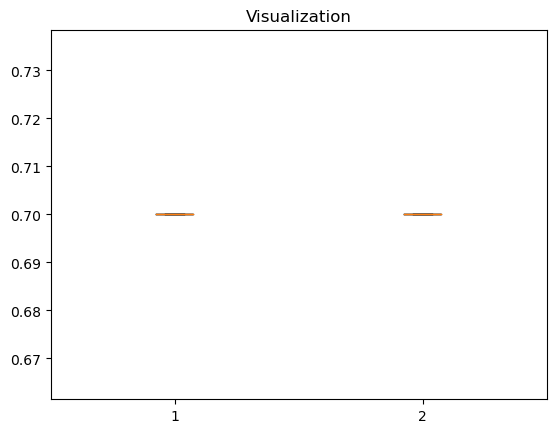

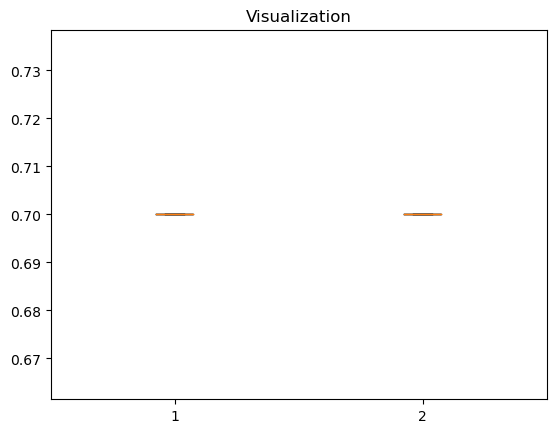

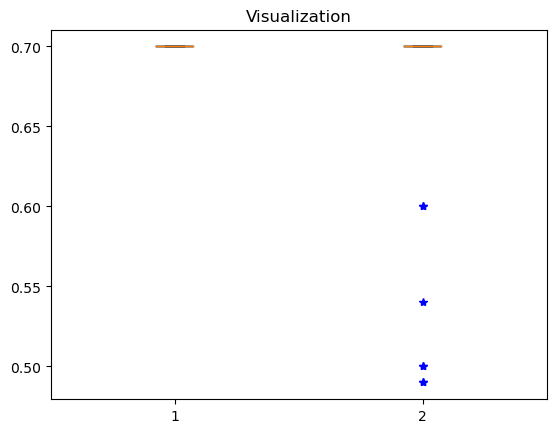

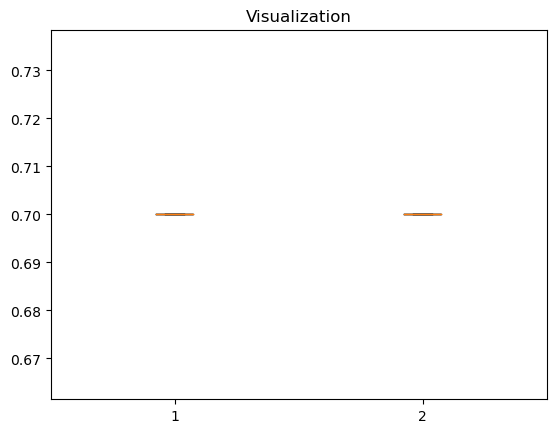

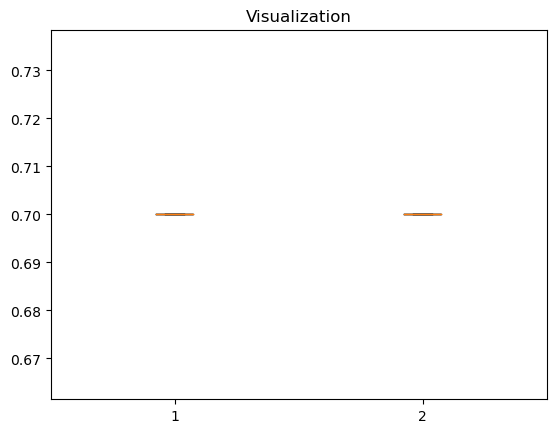

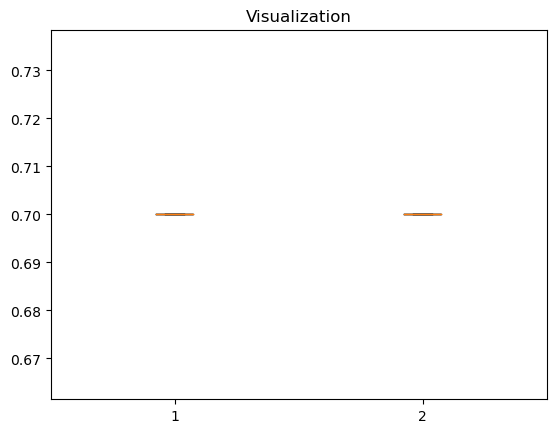

In [144]:
fig, ax = plt.subplots()

ax.boxplot([train_type_0['out_pressure'], test_type_0['out_pressure']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2])
plt.show()
fig, ax = plt.subplots()

ax.boxplot([train_type_1['out_pressure'], test_type_1['out_pressure']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2])
plt.show()

fig, ax = plt.subplots()

ax.boxplot([train_type_2['out_pressure'], test_type_2['out_pressure']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2])
plt.show()
fig, ax = plt.subplots()

ax.boxplot([train_type_3['out_pressure'], test_type_3['out_pressure']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2])
plt.show()

fig, ax = plt.subplots()

ax.boxplot([train_type_4['out_pressure'], test_type_4['out_pressure']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2])
plt.show()
fig, ax = plt.subplots()

ax.boxplot([train_type_5['out_pressure'], test_type_5['out_pressure']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2])
plt.show()

fig, ax = plt.subplots()

ax.boxplot([train_type_6['out_pressure'], test_type_6['out_pressure']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2])
plt.show()
fig, ax = plt.subplots()

ax.boxplot([train_type_7['out_pressure'], test_type_7['out_pressure']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2])
plt.show()



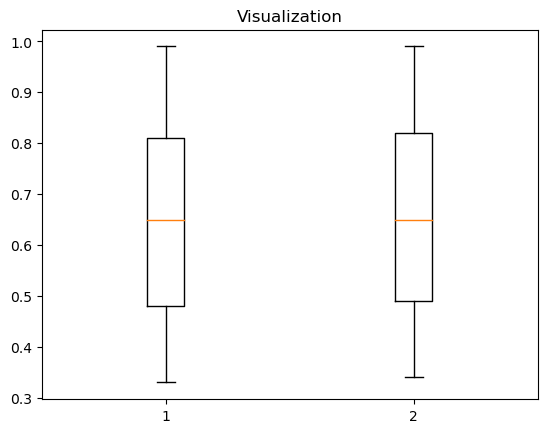

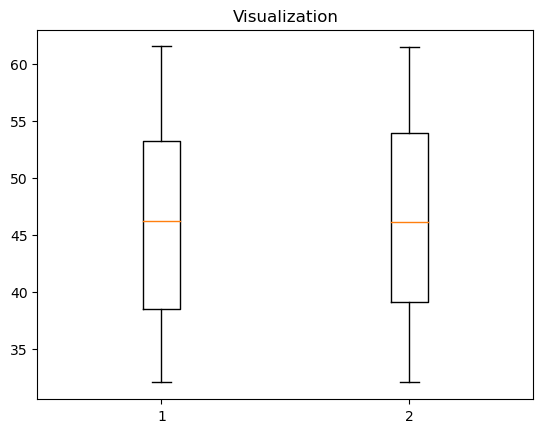

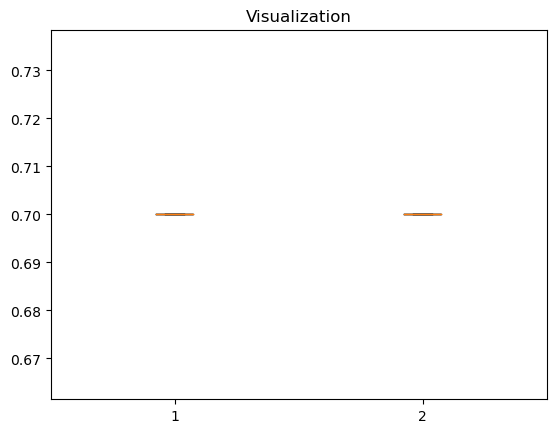

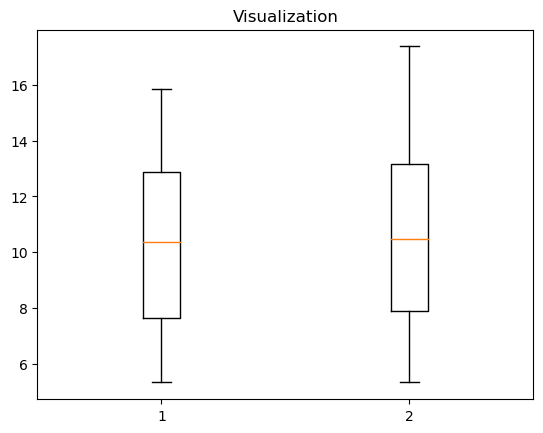

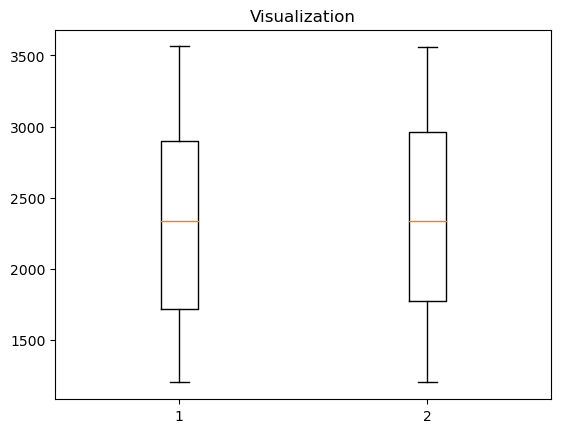

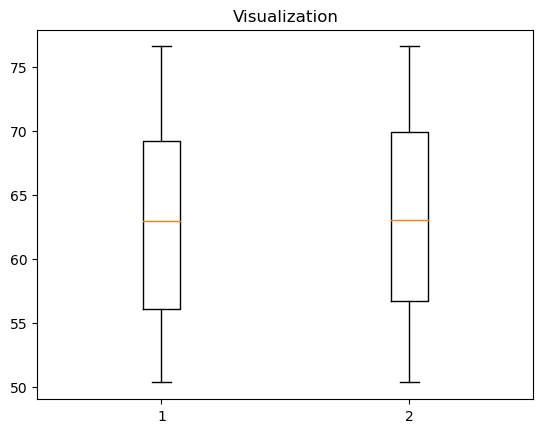

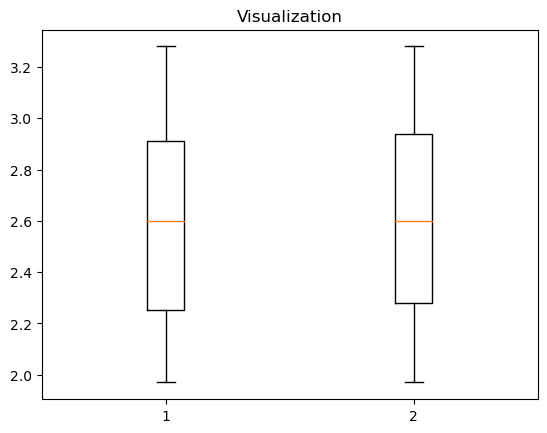

In [147]:
fig, ax = plt.subplots()

ax.boxplot([train_type_2['air_inflow'], test_type_2['air_inflow']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2])
plt.show()
fig, ax = plt.subplots()

ax.boxplot([train_type_2['air_end_temp'], test_type_2['air_end_temp']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2])
plt.show()

fig, ax = plt.subplots()

ax.boxplot([train_type_2['out_pressure'], test_type_2['out_pressure']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2])
plt.show()
fig, ax = plt.subplots()

ax.boxplot([train_type_2['motor_current'], test_type_2['motor_current']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2])
plt.show()
fig, ax = plt.subplots()

ax.boxplot([train_type_2['motor_rpm'], test_type_2['motor_rpm']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2])
plt.show()
fig, ax = plt.subplots()

ax.boxplot([train_type_2['motor_temp'], test_type_2['motor_temp']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2])
plt.show()
fig, ax = plt.subplots()

ax.boxplot([train_type_2['motor_vibe'], test_type_2['motor_vibe']], sym="b*")
plt.title('Visualization')

plt.xticks([1,2])
plt.show()

# Data preprocessing

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_91699/4019872682.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_each_list[i]['HP'] = 30
/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_91699/4019872682.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_each_list[i]['HP'] = 20
/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_91699/4019872682.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

      air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0           1.59         41.00           0.7          20.53     1680.0   
1           2.97         59.28           0.7          38.40     3142.0   
2           1.91         45.29           0.7          24.73     2023.0   
3           2.37         51.33           0.7          30.63     2506.0   
4           1.90         45.21           0.7          24.65     2017.0   
...          ...           ...           ...            ...        ...   
2458        2.28         50.20           0.7          29.53     2416.0   
2459        2.04         46.94           0.7          26.34     2155.0   
2460        1.19         35.74           0.7          15.39     1259.0   
2461        1.21         36.00           0.7          15.64     1280.0   
2462        2.72         55.99           0.7          35.19     2879.0   

      motor_temp  motor_vibe  type  HP  
0          58.67        2.93     0  30  
1          74.91        3.75 

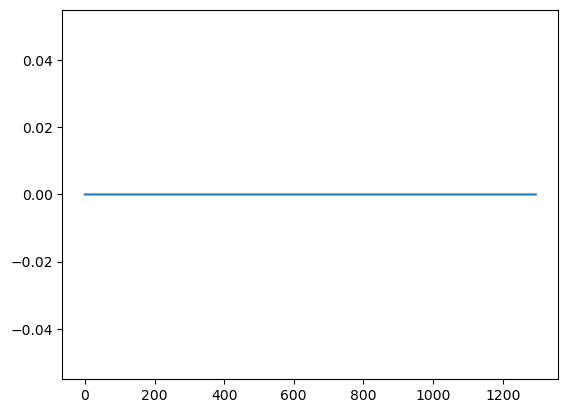


(array([0, 1]), array([1076,   31]))


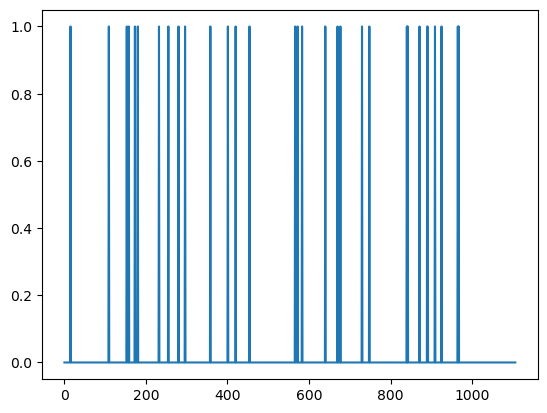


(array([0, 1]), array([916, 182]))


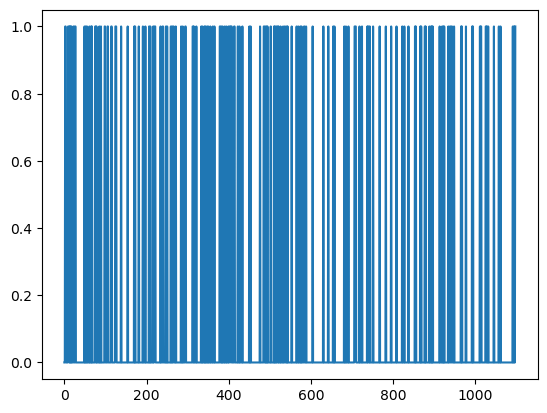


(array([0, 1]), array([399, 519]))


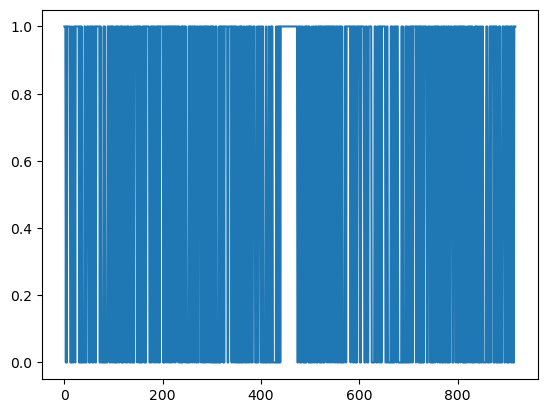


(array([0]), array([918]))


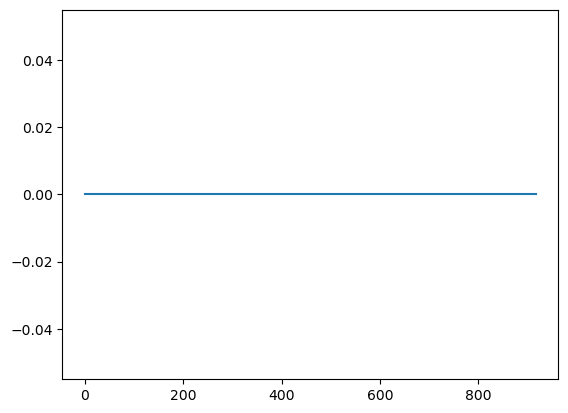


(array([0]), array([747]))


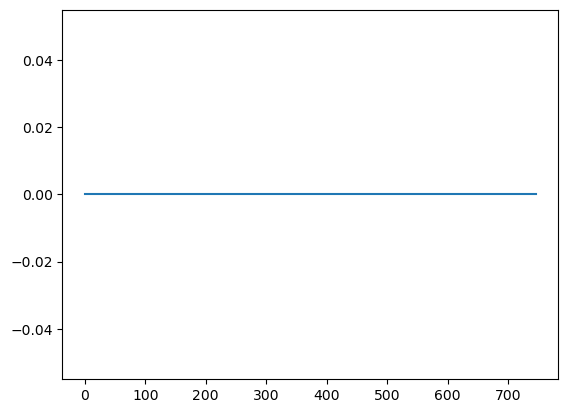


(array([0]), array([747]))


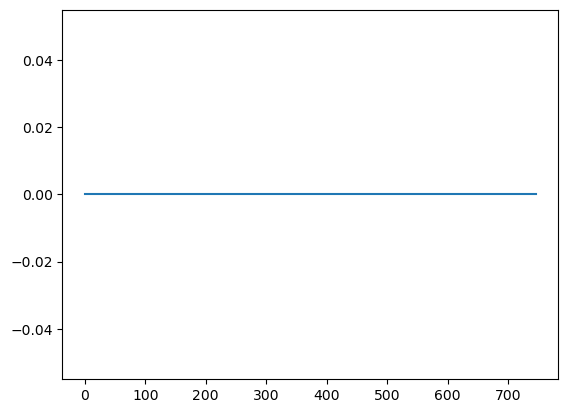


(array([0]), array([558]))


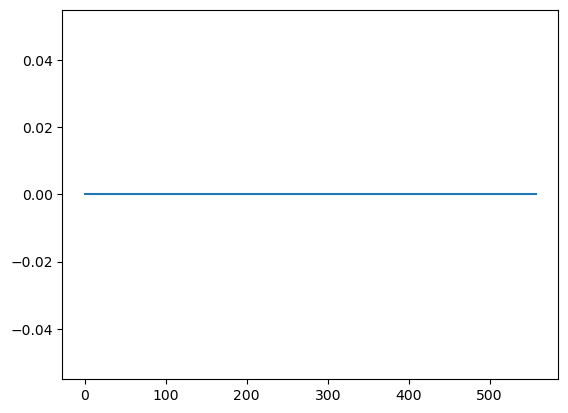

In [25]:
train_each_list = []
train_each_list.append(train_df.loc[train_df['type']==0])
train_each_list.append(train_df.loc[train_df['type']==1])
train_each_list.append(train_df.loc[train_df['type']==2])
train_each_list.append(train_df.loc[train_df['type']==3])
train_each_list.append(train_df.loc[train_df['type']==4])
train_each_list.append(train_df.loc[train_df['type']==5])
train_each_list.append(train_df.loc[train_df['type']==6])
train_each_list.append(train_df.loc[train_df['type']==7])

for i in range(8):
    if i == 0 or i == 4 or i == 5 or i ==6 or i ==7:
        train_each_list[i]['HP'] = 30
    elif i == 1:
        train_each_list[i]['HP'] = 20
    elif i == 2:
        train_each_list[i]['HP'] = 10
    elif i == 3:
        train_each_list[i]['HP'] = 50
train_added = pd.concat(train_each_list,axis=0)
print(train_added)

train_added = train_added.loc[train_added['motor_vibe'] < 10]
train_data_drop = train_added.drop('type', axis=1)
train_data_drop.reset_index(drop=True, inplace=True)
train_x, val_x = train_test_split(train_data_drop, test_size = 0.1, random_state=SEED, shuffle=True)

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
val_x = scaler.transform(val_x)

train_y = [0  for i in range(len(train_x))]

n = 100
con = 0.1
iso = IsolationForest(n_estimators=n, contamination=con, bootstrap = True, random_state=SEED)
iso.fit(train_x, train_y)

pred = iso.predict(train_x)

print(np.unique(pred, return_counts=True))


test_each_list = []
test_each_list.append(test_df.loc[test_df['type']==0])
test_each_list.append(test_df.loc[test_df['type']==1])
test_each_list.append(test_df.loc[test_df['type']==2])
test_each_list.append(test_df.loc[test_df['type']==3])
test_each_list.append(test_df.loc[test_df['type']==4])
test_each_list.append(test_df.loc[test_df['type']==5])
test_each_list.append(test_df.loc[test_df['type']==6])
test_each_list.append(test_df.loc[test_df['type']==7])

for i in range(8):
    if i == 0 or i == 4 or i == 5 or i ==6 or i ==7:
        test_each_list[i]['HP'] = 30
    elif i == 1:
        test_each_list[i]['HP'] = 20
    elif i == 2:
        test_each_list[i]['HP'] = 10
    elif i == 3:
        test_each_list[i]['HP'] = 50
test_added = pd.concat(test_each_list,axis=0)
print(test_added)

for i in range(len(test_each_list)):
    print()
    test_data_drop =  test_each_list[i].drop('type', axis=1)
    test_data_drop.reset_index(drop=True, inplace=True)
    test_x = scaler.transform(test_data_drop)
    test_pred = iso.predict(test_x)
    for i in range(len(test_pred)):
        if test_pred[i] == 1:
            test_pred[i] =0
        else:
            test_pred[i] =1
    print(np.unique(test_pred,return_counts=True))
    plt.plot(test_pred)
    plt.show()

In [140]:
n = 100
con = 0.01
iso = IsolationForest(n_estimators=n, contamination=con, bootstrap = True, random_state=SEED)
iso.fit(train_x, train_y)

pred = iso.predict(train_x)

print(np.unique(pred, return_counts=True))



(array([-1,  1]), array([  25, 2438]))


In [141]:
test_df_drop = test_df.drop('type', axis=1)
test_x = scaler.transform(test_df_drop)

In [142]:
test_pred = iso.predict(test_x)

In [143]:
for i in range(len(test_pred)):
    if test_pred[i] == 1:
        test_pred[i] =0
    else:
        test_pred[i] =1
print(np.unique(test_pred,return_counts=True))
         

(array([0, 1]), array([7326,   63]))


In [138]:
submit = pd.read_csv('./dataset/answer_sample.csv')
submit['label'] = test_pred

In [139]:
submit.to_csv(f'./answer_isolationforest_{n}_{con}.csv')